# Rule-based Relation Extraction
Uses a lot of hand-written patterns for extracting information from the natural language text.
<br>
<br>
[Automatic Acquisition of Hyponyms from Large Text Corpora](http://people.ischool.berkeley.edu/~hearst/papers/coling92.pdf)
<br>
**Marti Hearst** built a set of text-patterns that can be used for extracting meaningful information from text. These patterns are known as **Hearst Patterns**. These are lexico-syntactic patterns used to recognize hyponymy. For example,

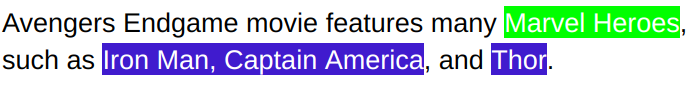

Here, "Marvel Heroes" is a **hypernym** and "Iron Man", "Captain America", and "Thor" are **hyponyms**. We can formalize this pattern as “X such as Y”, where X is the hypernym, and Y is the hyponym. Some other patterns are:
![patterns.png](https://cdn.analyticsvidhya.com/wp-content/uploads/2019/09/hearst_patterns-768x435.png)

Compared to using regular expressions on raw text, spaCy’s rule-based matcher engines and components not only let you find the words and phrases you’re looking for – they also give you access to the tokens within the document and their relationships. This means you can easily access and analyze the surrounding tokens, merge spans into single tokens or add entries to the named entities in doc.ents.

## Using Spacy's Matcher

In [28]:
# Importing Libraries
import spacy

from spacy.matcher import Matcher 
from spacy import displacy

In [29]:
# load spaCy model
nlp = spacy.load("en_core_web_sm")

### Pattern 1: **X** such as **Y**

In [31]:
# Define string
text="Developed countries such as USA have a better healthcare infrastructure compared to developing countries."

# Create spaCy object
doc=nlp(text)

In [32]:
# Print POS tag, and dependency tags
for token in doc:
  print(token.text,'=>',token.pos_,'=>',token.dep_)

Developed => VERB => amod
countries => NOUN => nsubj
such => ADJ => amod
as => SCONJ => prep
USA => PROPN => pobj
have => AUX => ROOT
a => DET => det
better => ADJ => amod
healthcare => NOUN => compound
infrastructure => NOUN => dobj
compared => VERB => prep
to => ADP => prep
developing => VERB => amod
countries => NOUN => pobj
. => PUNCT => punct


Pattern: <code>NOUN + such + as + PROPN</code>

In [33]:
#define the pattern 
pattern = [{'POS':'NOUN'}, 
           {'LOWER': 'such'}, 
           {'LOWER': 'as'}, 
           {'POS': 'PROPN'}]

See the complete list of attributes [here](https://spacy.io/usage/rule-based-matching#adding-patterns-attributes)

In [34]:
# Create Matcher Object
matcher=Matcher(nlp.vocab)

In [35]:
# Add the rule to matcher
matcher.add("Pattern X such as Y",None,pattern)

In [36]:
# Running pattern on text
matches = matcher(doc)

The matcher returns a list of (match_id, start, end) tuples – in this case, [('15578876784678163569', 0, 3)], which maps to the span doc[0:3] of our original document. The match_id is the hash value of the string ID “HelloWorld”. To get the string value, you can look up the ID in the StringStore.

In [37]:
matches

[(17711623125337077988, 1, 5)]

In [38]:
# Extracting matched string
span=doc[matches[0][1]:matches[0][2]]
print(span)

countries such as USA


In [15]:
# Define another string
text="I love eating healthy fruits such as Apple. I like supercars such as Lamborghini."

# Create doc object
doc=nlp(text)

In [16]:
# Running pattern on text
matches = matcher(doc)

In [17]:
# Print extracted text
for match in matches:
  print(doc[match[1]:match[2]])

fruits such as Apple
supercars such as Lamborghini


### Pattern 2: **X** and/or other **Y**

In [18]:
# Define the string and create Doc object
doc=nlp("In this way you can disinfect your car and other vehicles.")

In [19]:
# Print POS tag, and dependency tags
for token in doc:
  print(token.text,'=>',token.pos_,'=>',token.dep_)

In => ADP => prep
this => DET => det
way => NOUN => pobj
you => PRON => nsubj
can => VERB => aux
disinfect => VERB => ROOT
your => DET => poss
car => NOUN => dobj
and => CCONJ => cc
other => ADJ => amod
vehicles => NOUN => conj
. => PUNCT => punct


Pattern: <code>NOUN + and + other + NOUN</code>

In [20]:
#Define the pattern 
pattern = [{'POS':'NOUN'}, 
           {'LOWER': 'and'},
           {'LOWER': 'other'}, 
           {'POS': 'NOUN'}]

In [21]:
# Create Matcher Object
matcher=Matcher(nlp.vocab)

# Add the rule to matcher
matcher.add("Pattern X and other Y",None,pattern)

In [22]:
# Running pattern on text
matches = matcher(doc)

# Print extracted text
for match in matches:
  print(doc[match[1]:match[2]])

car and other vehicles


In [23]:
# Define another string and create doc object
doc=nlp("Here is how to keep your TV or other electronics clean.")

# Running pattern on text
matches = matcher(doc)

# Print extracted text
for match in matches:
  print(doc[match[1]:match[2]])

In [24]:
# Print POS tag, and dependency tags
for token in doc:
  print(token.text,'=>',token.pos_,'=>',token.dep_)

Here => ADV => advmod
is => AUX => ROOT
how => ADV => advmod
to => PART => aux
keep => VERB => xcomp
your => DET => poss
TV => NOUN => dobj
or => CCONJ => cc
other => ADJ => amod
electronics => NOUN => conj
clean => ADJ => oprd
. => PUNCT => punct


**Quantifiers:**
- **!** - Negation
- **?** - Optional
- **+** - 1 or more
- **\*** - 0 or more

Pattern: <code>NOUN + and/or + other + NOUN</code>

In [ ]:
#Define the pattern 
pattern = [{'POS':'NOUN'}, 
           {'LOWER': 'and','OP':'?'},
           {'LOWER':'or','OP':'?'},
           {'LOWER': 'other'}, 
           {'POS': 'NOUN'}]

In [ ]:
# Create Matcher Object
matcher=Matcher(nlp.vocab)

# Add the rule to matcher
matcher.add("Pattern X and/or Y",None,pattern)

In [ ]:
# Running pattern on text
matches = matcher(doc)

# Print extracted text
for match in matches:
  print(doc[match[1]:match[2]])

TV or other electronics


#### Drawbacks:
- Hides implementation details
- Doesn't work on patterns in which words do not immediately follow each other. E.g.,
<br>
<code>Subject + Auxiliary + Verb + ... + Object</code>

## Using Custom Functions

### Pattern 3: <code>X going Y</code>

In [39]:
# Define the string and create doc object
doc=nlp("John is going to Berlin.")

In [40]:
# Visualizing dependency tree
displacy.render(doc,style='dep',jupyter=True)

In [ ]:
# Function for extracting the relation
def x_going_y(doc):
  # Proceed if at least 3 words are present
  if len(doc)>=3:
    matches=[]

    for i in range(len(doc)):
      x=''
      y=''
      
      # Checking if the root word is going
      if ((doc[i].dep_=='ROOT') and (doc[i].text=='going')):
        # Accessing subtree
        for token in doc[i].subtree:
          # Checking if token is subject
          if token.dep_.startswith('nsubj'):
            x=token.text
          # Checking if token is object
          if token.dep_.endswith('obj'):
            y=token.text
        # Appending the triple into list
        matches.append((x,doc[i].text,y))
    return matches
  return []

In [ ]:
# Running function on text
x_going_y(doc)

[('John', 'going', 'Berlin')]

In [ ]:
x_going_y(nlp('Sam was going on vacation to Mumbai. But, the train was going to Goa.'))

[('Sam', 'going', 'Mumbai'), ('train', 'going', 'Goa')]